In [540]:
# Authors: Luke Majors, Colin Pollard, Ian Lavin
# ECE 6990 - Computational Photography
# Wildfire Demarcation Algorithm Project
# This code defines and trains a CNN used for the binary classification 
# of LWIR images. The algorithm predicts if an image contains a wildfire
# hotspot or not.

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Index used for saving unique results
trial_num = 0

# Binary Classification

### 1. Load Data

In [541]:
# We're use 16-bit grayscale images of 2 classes - contains hotspots and doesn't contain hotspots
    
# The images are separated into train and test directories.
# Within each directory is a directory for each class containing all the images for that class
    # Train/Hotspot, and Train/NoFire
    # Test/Hotspot, and Test/NoFire

def gen_data(data_dir_train, data_dir_test):
    data_gen = tf.keras.preprocessing.image.ImageDataGenerator (
        rotation_range = 20,
        width_shift_range= 0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        validation_split=0.2,
        rescale=1/255.
    )
    val_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255, 
        validation_split=0.2
    )
    test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255
    )

    train_ds = data_gen.flow_from_directory(
        directory=data_dir_train,
        subset='training',
        color_mode='grayscale',
        class_mode='binary',
        target_size=(120, 160),
        seed=123,
        batch_size=batch_size,
        classes=['hotspot', 'noFire'])
    
    val_ds = val_data_gen.flow_from_directory(
        directory=data_dir_train,
        subset='validation',
        color_mode='grayscale',
        class_mode='binary',
        target_size=(120, 160),
        seed=123,
        batch_size=batch_size,
        classes=['hotspot', 'noFire'],
        shuffle=False)

    test_ds = test_data_gen.flow_from_directory(
        directory=data_dir_test,
        target_size=(120, 160),
        color_mode='grayscale',
        seed=123,
        class_mode='binary',
        classes=['hotspot','noFire'],
        batch_size=batch_size,
        shuffle=False)
    

    return train_ds, val_ds, test_ds

# Unique Trial Name to save figures
trial_name = []
trial_num += 1

batch_size = 16
trial_name.append('bs=' + str(batch_size)+'_')
data_dir_train = r'TrainingData'
data_dir_test = r'TestingData'
train_ds, val_ds, test_ds = gen_data(data_dir_train, data_dir_test)

datagen = tf.keras.preprocessing.image.ImageDataGenerator()

Found 163 images belonging to 2 classes.
Found 39 images belonging to 2 classes.
Found 44 images belonging to 2 classes.


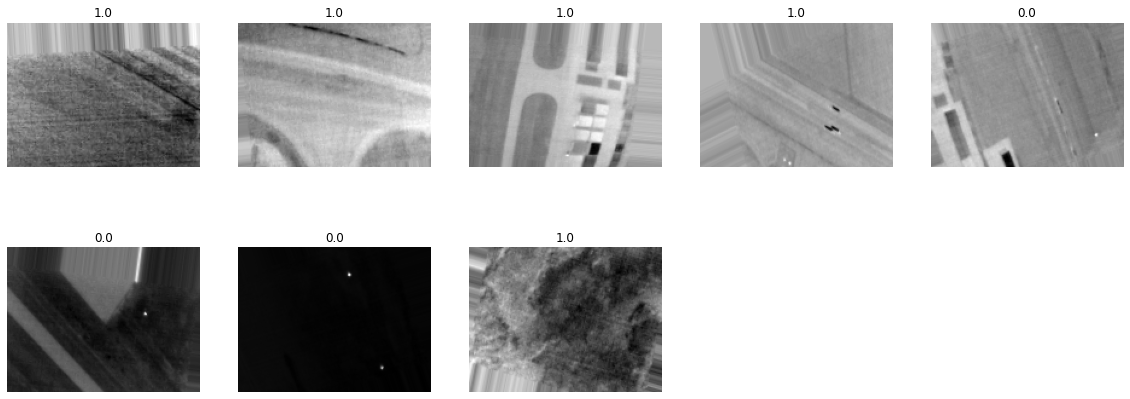

In [542]:
# Display some sample inputs with their labels
plt.figure(figsize=(20, 20))
for batch_images, batch_labels in train_ds:
    for i in range(8):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(batch_images[i].astype("float32"), cmap='gray')
        plt.title('{}'.format(batch_labels[i]))
        plt.axis("off")
    break

## 2. Build Model

In [544]:
# in this model we take the resnet50 from above, chop of it's classification head, and replace it with our own.
    # the classifcation head includes dropout which randomly sets weights to 0 during training.
    # typically dropout will improve test accurcy.
def build_model():

    # here we use the functional api. instead of above where we added layers sequentially to a model, 
        # we create layer objects then pass the output into any other layer we want 
    input = tf.keras.layers.Input(shape=(120, 160, 1))
    x = tf.keras.applications.ResNet50(include_top=False, weights=None, input_tensor=input, pooling='max')(input)
    
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Flatten()(x)
    
    l1 = tf.keras.layers.Dense(512, activation="relu", name="dense_1_out")(x)
    l1 = tf.keras.layers.BatchNormalization()(l1)
    l1 = tf.keras.layers.Dropout(0.5)(l1)
    
    l2 = tf.keras.layers.Dense(128, activation="relu", name="dense_2_out")(l1)
    l2 = tf.keras.layers.BatchNormalization()(l2)
    l2 = tf.keras.layers.Dropout(0.5)(l2)
    
    # Used to be softmax
    output = tf.keras.layers.Dense(1, activation="softmax")(l2)

    model = tf.keras.models.Model(input, output)
    return model

# Model we ended up using for training that gave us better results
# Model taken from https://towardsdatascience.com/10-minutes-to-building-a-cnn-binary-image-classifier-in-tensorflow-4e216b2034aa
def new_model():
    model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 200x200 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='LeakyReLU', input_shape=(120, 160, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='LeakyReLU'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='LeakyReLU'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='LeakyReLU'),
    tf.keras.layers.MaxPooling2D(2,2),
    # # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='LeakyReLU'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='LeakyReLU'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('dandelions') and 1 for the other ('grass')
    tf.keras.layers.Dense(1, activation='sigmoid')])
    return model

model = new_model()
model.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_217 (Conv2D)         (None, 118, 158, 16)      160       
                                                                 
 max_pooling2d_217 (MaxPooli  (None, 59, 79, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_218 (Conv2D)         (None, 57, 77, 32)        4640      
                                                                 
 max_pooling2d_218 (MaxPooli  (None, 28, 38, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_219 (Conv2D)         (None, 26, 36, 64)        18496     
                                                                 
 max_pooling2d_219 (MaxPooli  (None, 13, 18, 64)     

## 3. Optimization

In [545]:
# Similar optimization scheme as before but we have changed it to binary classification
def define_optimization(model, loss, learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Specify metrics
    metrics = [tf.keras.metrics.BinaryAccuracy()]
    #metrics = [tf.keras.metrics.AUC(), tf.keras.metrics.MeanAbsoluteError()]
    #metrics = [tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.AUC(), tf.keras.metrics.BinaryAccuracy()]

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics)
trial_name.append('')

## 4. Train

In [546]:
# Define training parameters
epochs = 100
learning_rate = 1e-3
loss = tf.keras.losses.BinaryCrossentropy()
#loss = tf.keras.losses.MeanSquaredError()

# Generate filename to save results with
trial_name.append('ep=' + str(epochs) + '_')
trial_name.append('lr=' + str(learning_rate) +'_')
trial_name.append('loss=BCE_')
trial_name.append(str(trial_num)+'_')
trial_name = ''.join(trial_name)

define_optimization(model, loss, learning_rate)
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, batch_size=batch_size, verbose=2)

Epoch 1/100
11/11 - 1s - loss: 1.1468 - binary_accuracy: 0.3742 - val_loss: 0.6970 - val_binary_accuracy: 0.4872 - 993ms/epoch - 90ms/step
Epoch 2/100
11/11 - 1s - loss: 0.7162 - binary_accuracy: 0.4479 - val_loss: 0.6958 - val_binary_accuracy: 0.5128 - 749ms/epoch - 68ms/step
Epoch 3/100
11/11 - 1s - loss: 0.6968 - binary_accuracy: 0.5521 - val_loss: 0.6975 - val_binary_accuracy: 0.4872 - 867ms/epoch - 79ms/step
Epoch 4/100
11/11 - 1s - loss: 0.7038 - binary_accuracy: 0.5031 - val_loss: 0.6924 - val_binary_accuracy: 0.5128 - 725ms/epoch - 66ms/step
Epoch 5/100
11/11 - 1s - loss: 0.6980 - binary_accuracy: 0.5215 - val_loss: 0.6938 - val_binary_accuracy: 0.4872 - 607ms/epoch - 55ms/step
Epoch 6/100
11/11 - 1s - loss: 0.6937 - binary_accuracy: 0.5092 - val_loss: 0.6930 - val_binary_accuracy: 0.4872 - 679ms/epoch - 62ms/step
Epoch 7/100
11/11 - 1s - loss: 0.6894 - binary_accuracy: 0.5890 - val_loss: 0.6940 - val_binary_accuracy: 0.4872 - 610ms/epoch - 55ms/step
Epoch 8/100
11/11 - 1s - lo

## 5. Evaluate

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


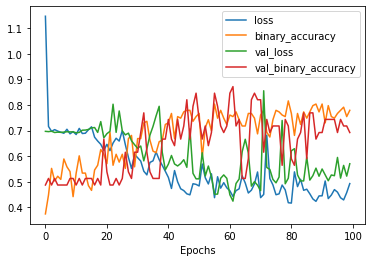

In [547]:
# Plot the available training data and save the figure
for k in history.history.keys():
	if 'binary_accuracy' in k or 'loss' in k:
		plt.plot(history.history[k], label=k)
plt.legend()
plt.xlabel('Epochs')
plt.savefig('Figures/' + trial_name + 'loss.png')

In [548]:
# Evaluate the model and save its metrics to a text file
eval = model.evaluate(test_ds, verbose=2)
predicted = model.predict(test_ds)
#print(predicted)
f = open('Figures/'+trial_name+'.txt', 'w')
f.write('Loss = ' + str(eval[0]) + '\n')
f.write('Binary Accuracy = ' + str(eval[1]) + '\n')

3/3 - 0s - loss: 0.4508 - binary_accuracy: 0.8182 - 120ms/epoch - 40ms/step


37

## 6. Generate Confusion Matrix

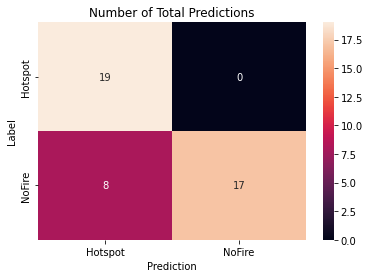

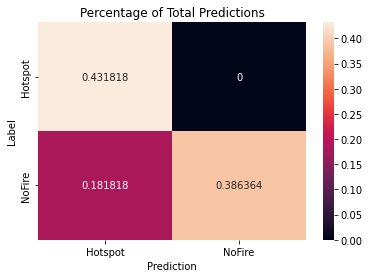

In [549]:
# For each value in predicted matrix, set to 0 if less that 0.5, or 1 if greater
_predicted = [1 if x > 0.5 else 0 for x in predicted]

# Generate and plot the confusion matrix showing total number of predictions
conf_matrix = tf.math.confusion_matrix(test_ds.labels, _predicted)
plt.figure()
plt.title("Number of Total Predictions")
label_names = ['Hotspot', 'NoFire']
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('Figures/' + ''.join(trial_name) + 'number.png')

# Generate and plot the confusion matrix showing percentages of predictions
norm_conf_matrix = conf_matrix/len(_predicted)
plt.figure()
plt.title("Percentage of Total Predictions")
sns.heatmap(norm_conf_matrix, annot=True, fmt='g', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('Figures/' + trial_name + 'percent.png')

## 7. ROC Curves

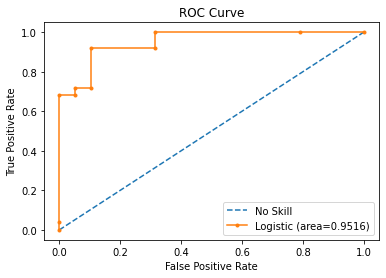

In [550]:
# Plot the Roc curves
plt.figure()
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
fpr, tpr, _ = roc_curve(test_ds.labels, predicted[:,0])
auc_roc = auc(fpr, tpr)
l='Logistic (area='+ str( '{:.4f}'.format(auc_roc) ) +')'
plt.plot(fpr, tpr, marker='.', label=l)
plt.legend()
plt.savefig('Figures/' + trial_name + 'roc.png')
